In [1]:
# Generic OpenAI-compatible endpoint using ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage
from IPython.display import Image, display

import os
default_model_name = os.environ["OPENAI_MODEL"]
pg_connection = os.environ["PGVECTOR_CONNECTION_STRING"]
llm = ChatOpenAI(model=default_model_name,temperature=0)

In [2]:
def print_messages(result, last_n=None):
    """
    Fungsi untuk menampilkan pesan.
    Jika last_n diisi (misal: 2), hanya menampilkan n pesan terakhir.
    """
    messages = result.get("messages", [])
    
    # Jika last_n diberikan, kita slice list-nya (misal: messages[-2:])
    if last_n is not None:
        messages = messages[-last_n:]
    
    for msg in messages:
        if "type" in msg:
            role = "😎 USER" if msg.type == "human" else "🤖 BOT"
            print(f"{role}: {msg.content}")

c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:937: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `BaseMessage` to V2.
  warnings.warn(


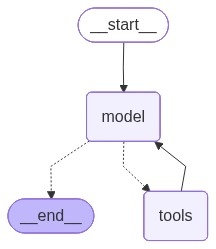

In [3]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import operator
import re

@tool
def calculator(query: str) -> str:
    """Alat kalkulator sederhana. Masukan harus berupa ekspresi matematika."""
    # Hanya izinkan angka, operator matematika, dan spasi
    if not re.match(r'^[0-9+\-*/(). ]+$', query):
        raise ValueError("Ekspresi hanya boleh mengandung angka dan operator matematika (+, -, *, /, ., ()")
    
    try:
        # Evaluasi ekspresi matematika dengan aman
        # Membatasi operasi hanya ke operator matematika dasar
        allowed_operators = {
            ast.Add: operator.add,
            ast.Sub: operator.sub,
            ast.Mult: operator.mul,
            ast.Div: operator.truediv,
            ast.USub: operator.neg,
            ast.UAdd: operator.pos,
        }

        def eval_math_expr(node):
            if isinstance(node, ast.Constant):  # Angka
                return node.value
            elif isinstance(node, ast.Num):  # Untuk Python versi lama
                return node.n
            elif isinstance(node, ast.BinOp):  # Operasi biner
                left = eval_math_expr(node.left)
                right = eval_math_expr(node.right)
                return allowed_operators[type(node.op)](left, right)
            elif isinstance(node, ast.UnaryOp):  # Operasi unary
                operand = eval_math_expr(node.operand)
                return allowed_operators[type(node.op)](operand)
            else:
                raise TypeError(f"Operasi tidak dikenal: {type(node)}")

        node = ast.parse(query, mode='eval').body
        result = eval_math_expr(node)
        
        # Konversi hasil ke string
        if isinstance(result, float) and result.is_integer():
            return str(int(result))
        return str(result)
    except Exception as e:
        raise ValueError(f"Ekspresi matematika tidak valid: {str(e)}")

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(model=default_model_name,temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

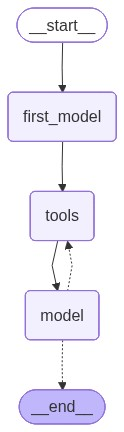

In [4]:
from uuid import uuid4
 
from langchain_core.messages import  ToolCall
def first_model(state: State) -> State:
    query = state["messages"][-1].content
    search_tool_call = ToolCall(
        name="duckduckgo_search", args={"query": query}, id=uuid4().hex
    )
    return {"messages": AIMessage(content="", tool_calls=[search_tool_call])}

builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
png_bytes =graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [13]:
input = {
    "messages": [
        HumanMessage("""hitler's age if still alive?""")
    ]
}
for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', id='63882c01-88e5-4211-bee3-f05ade2644cf', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': "hitler's age if still alive?"}, 'id': '707a2451541a4ba0b53dfac87a2a5e59', 'type': 'tool_call'}])}}


c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:61: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
c:\Projects\examples-code-id-langchain-learning\.venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:62: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'tools': {'messages': [ToolMessage(content="One of Hitler's key goals was Lebensraum (lit. 'living space') for the German people in Eastern Europe, and his aggressive, expansionist foreign policy is considered the primary cause of World War II in Europe. … Dec 9, 2025 · Adolf Hitler was the dictator of Nazi Germany who rose to power with his radical ideology. He was responsible for starting World War II and initiating the Holocaust. Dec 4, 2024 · Adolf Hitler (1889-1945) was the dictator of Nazi Germany from 1933. He gained power by making popular promises like improving Germany's economy and status in... Oct 29, 2009 · Hitler’s virulent anti-Semitism and obsessive pursuit of Aryan supremacy fueled the murder of some 6 million Jews, along with other victims of the Holocaust. Adolf Hitler was an Austrian-born German politician who was the dictator of Germany during the Nazi era, which lasted from 1933 until his suicide in 1945. He ro...", name='duckduckgo_search', id='96abd2c3-4004-467